In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import EfficientNetV2B2
from sklearn.metrics import confusion_matrix, classification_report
import gradio as gr

In [2]:
dataset_dir= r"C:\Users\Nandu\Downloads\TrashType_Image_Dataset_1"
image_size = (124, 124)
batch_size = 32
seed = 42

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
)

Found 6091 files belonging to 6 classes.
Using 4873 files for training.


In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
)
val_class= val_ds.class_names

Found 6091 files belonging to 6 classes.
Using 1218 files for validation.


In [5]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_dat = val_ds.skip(val_batches // 2)
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [6]:
print(train_ds.class_names)
print(val_class)
print(len(train_ds.class_names))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
6


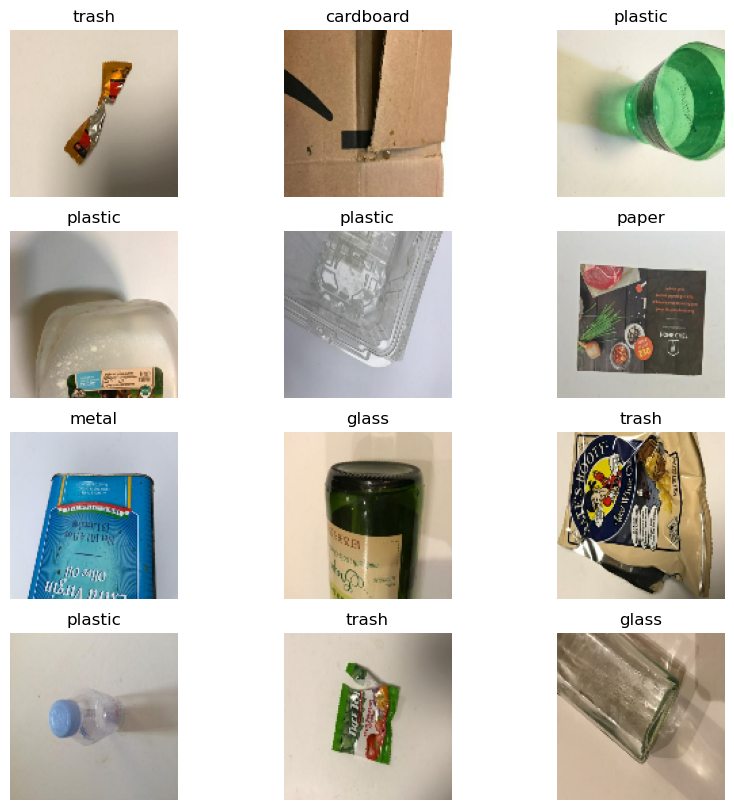

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")
        
    

In [8]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_name}

    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] +=1
            total +=1
    for k in counts:
        counts[k] = round((counts[k] / total) *100, 2)
        return counts

In [9]:

def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()


In [10]:
class_names = train_ds.class_names

def get_distribution(dataset, class_names):
    counts = {k: 0 for k in class_names}
    total = 0
    for images, labels in dataset:
        for label in labels:
            class_name = class_names[int(label)]
            counts[class_name] += 1
            total += 1

    if total == 0:
        return counts  
    for  k in counts:
        counts[k] = round((counts[k] / total) *100, 2)
    return counts

train_dist = get_distribution(train_ds, class_names)
val_dist = get_distribution(val_ds, class_names)
test_dist = get_distribution(test_ds, class_names)

overall_dist = {}
for k in class_names:
    overall_dist[k] = round((train_dist.get(k, 0) + val_dist.get(k, 0)) / 2)

# Print results
print("Train Distribution:", train_dist)
print("Validation Distribution:", val_dist)
print("Test Distribution:", test_dist)



Train Distribution: {'cardboard': 16.66, 'glass': 18.2, 'metal': 16.38, 'paper': 19.31, 'plastic': 17.48, 'trash': 11.96}
Validation Distribution: {'cardboard': 15.19, 'glass': 17.08, 'metal': 16.91, 'paper': 20.28, 'plastic': 18.39, 'trash': 12.15}
Test Distribution: {'cardboard': 15.79, 'glass': 16.78, 'metal': 17.27, 'paper': 20.89, 'plastic': 18.91, 'trash': 10.36}


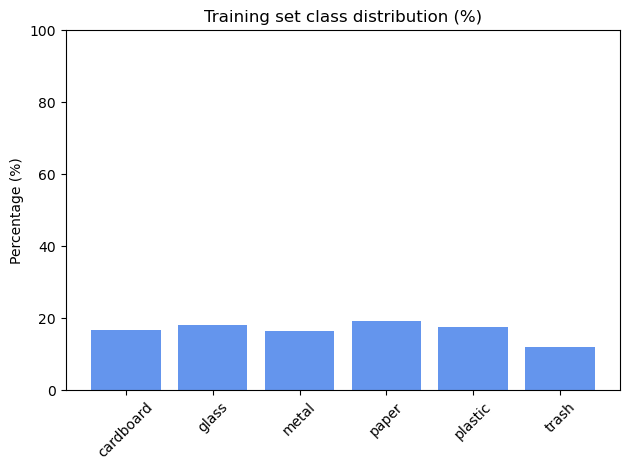

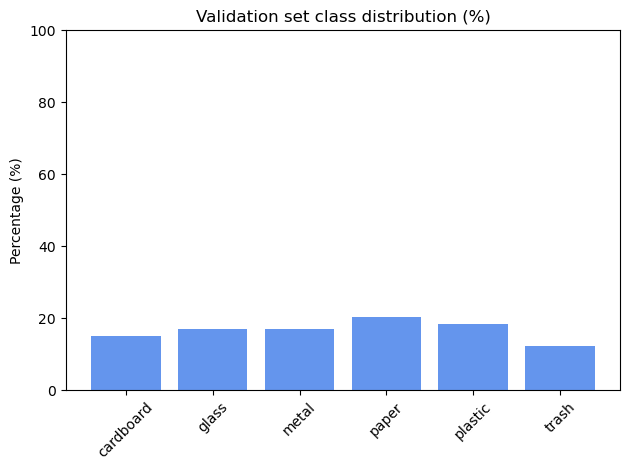

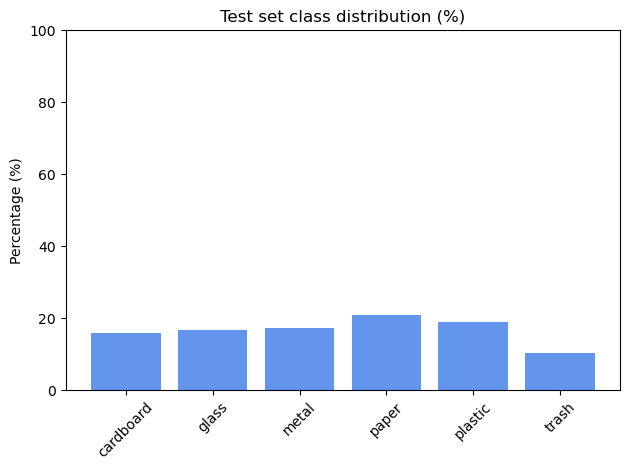

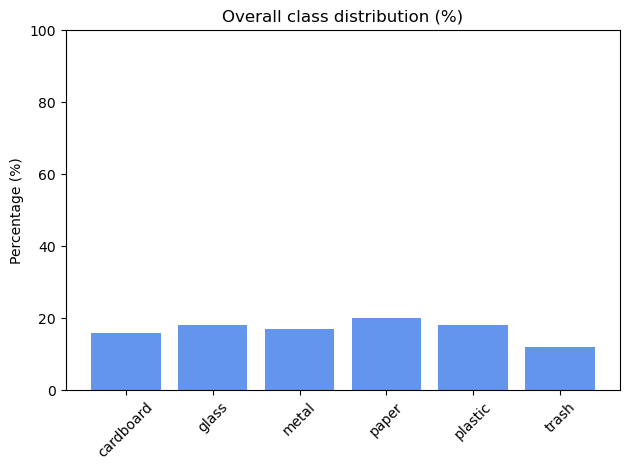

In [11]:
simple_bar_plot(train_dist, "Training set class distribution (%)")
simple_bar_plot(val_dist, "Validation set class distribution (%)")
simple_bar_plot(test_dist, "Test set class distribution (%)")
simple_bar_plot(overall_dist, "Overall class distribution (%)")

In [12]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for images, labels in train_ds:
    for label in labels.numpy():
        if isinstance(label, np.ndarray):
            label = np.argmax(label)
        class_counts[label] +=1
        all_labels.append(label)

class_weight_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)

class_weights = {i: w for i, w in zip(np.unique(all_labels), class_weight_array)}

            

In [13]:
print("Class Counts:", class_counts)
print("Class Weights:", class_weights)

Class Counts: {0: 812, 1: 887, 2: 798, 3: 941, 4: 852, 5: 583}
Class Weights: {0: 1.0002052545155993, 1: 0.9156332205937617, 2: 1.017752715121136, 3: 0.8630889125044279, 4: 0.9532472613458529, 5: 1.3930817610062893}


In [14]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomFlip(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [15]:
base_model = EfficientNetV2B2(include_top=False, input_shape=(124,124,3), include_preprocessing=True, weights='imagenet')

base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

In [16]:
model = Sequential([
    layers.Input(shape=(124, 124, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')
])

In [17]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
             

In [18]:
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [19]:
label_mapping = {label: idx for idx, label in enumerate(sorted(set(all_labels)))}
mapped_labels = [label_mapping[label] for label in all_labels]

from sklearn.utils.class_weight import compute_class_weight

class_weight_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(label_mapping)),
    y=mapped_labels
)
class_weights = {i: w for i,w in enumerate(class_weight_array)}

In [20]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 124, 124, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b2 (Functional)       │ (None, 4, 4, 1408)          │       8,769,374 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1408)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │           8,454 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,777,828 (33.48 MB)

 Trainable params: 7,974,642 (30.42 MB)

 Non-trainable params: 803,186 (3.06 MB)

In [21]:
base_model.summary()

Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 124, 124, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 124, 124, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 124, 124, 3)       │               0 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 62, 62, 32)        │             864 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 62, 62, 32)        │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 62, 62, 32)        │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_conv (Conv2D) │ (None, 62, 62, 16)        │           4,608 │ stem_activation[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_bn            │ (None, 62, 62, 16)        │              64 │ block1a_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_activation    │ (None, 62, 62, 16)        │               0 │ block1a_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_conv (Conv2D) │ (None, 62, 62, 16)        │           2,304 │ block1a_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_bn            │ (None, 62, 62, 16)        │              64 │ block1b_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_activation    │ (None, 62, 62, 16)        │               0 │ block1b_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_drop (Dropout)        │ (None, 62, 62, 16)        │               0 │ block1b_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_add (Add)             │ (None, 62, 62, 16)        │               0 │ block1b_drop[0][0],        │
│                               │                           │                 │ block1a_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_expand_conv (Conv2D)  │ (None, 31, 31, 64)        │           9,21

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 7,966,188 (30.39 MB)

 Non-trainable params: 803,186 (3.06 MB)

Epoch 1/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 894s 5s/step - accuracy: 0.4522 - loss: 1.4212 - val_accuracy: 0.8268 - val_loss: 0.5735
Epoch 2/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 700s 5s/step - accuracy: 0.8558 - loss: 0.4889 - val_accuracy: 0.9327 - val_loss: 0.2507
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 990s 6s/step - accuracy: 0.9335 - loss: 0.2444 - val_accuracy: 0.9614 - val_loss: 0.1505
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 545s 3s/step - accuracy: 0.9610 - loss: 0.1360 - val_accuracy: 0.9655 - val_loss: 0.1204
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 536s 4s/step - accuracy: 0.9732 - loss: 0.0855 - val_accuracy: 0.9688 - val_loss: 0.0954
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 701s 4s/step - accuracy: 0.9824 - loss: 0.0677 - val_accuracy: 0.9688 - val_loss: 0.0942
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 736s 5s/step - accuracy: 0.9851 - loss: 0.0499 - val_accuracy: 0.9696 - val_loss: 0.0862
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 540s 4s/step - accuracy: 0.9834 - loss: 0.0503 - val_accu

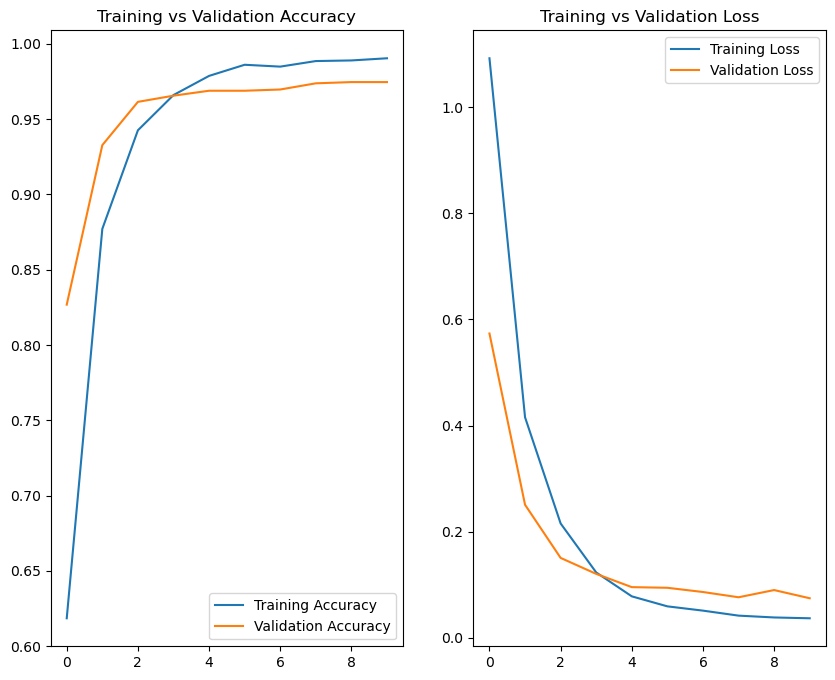

In [22]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')

plt.show()


In [23]:
loss, accuracy = model.evaluate(test_ds_eval)
print(f'Test accuracy is{accuracy: .4f}, Test loss is {loss:.4f}')

19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9830 - loss: 0.0844
Test accuracy is 0.9836, Test loss is 0.0649


In [24]:
y_true = np.concatenate([y.numpy() for x,y in test_ds_eval], axis=0)

y_pred_probs = model.predict(test_ds_eval)

y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)

print(cm)
print(classification_report(y_true, y_pred))


19/19 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step
[[ 85   0   0   1   0   0]
 [  0  94   1   0   4   0]
 [  0   1 115   0   1   0]
 [  0   0   0 116   0   1]
 [  0   0   1   0 118   0]
 [  0   0   0   0   0  70]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        86
           1       0.99      0.95      0.97        99
           2       0.98      0.98      0.98       117
           3       0.99      0.99      0.99       117
           4       0.96      0.99      0.98       119
           5       0.99      1.00      0.99        70

    accuracy                           0.98       608
   macro avg       0.98      0.98      0.98       608
weighted avg       0.98      0.98      0.98       608



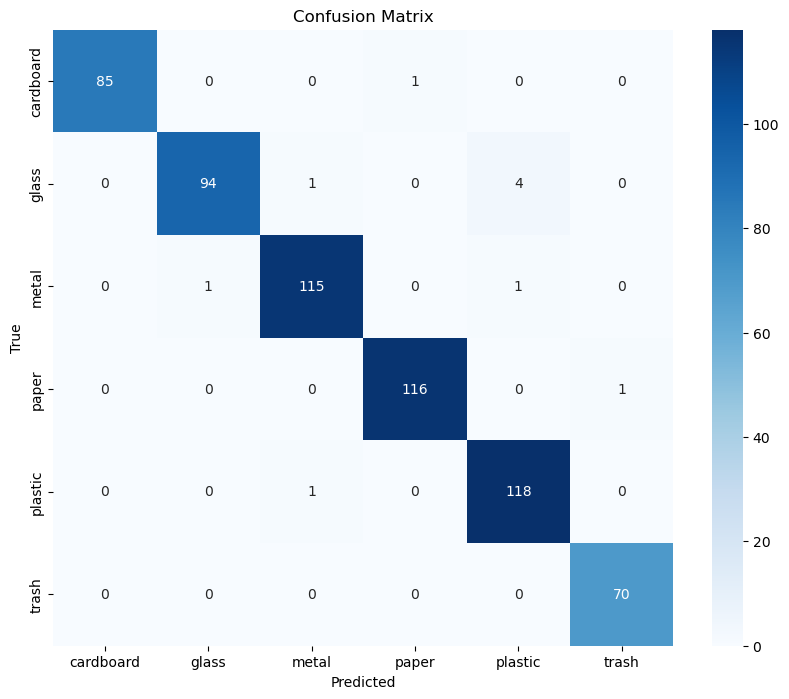

In [25]:
plt.figure(figsize=(10,8))

sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


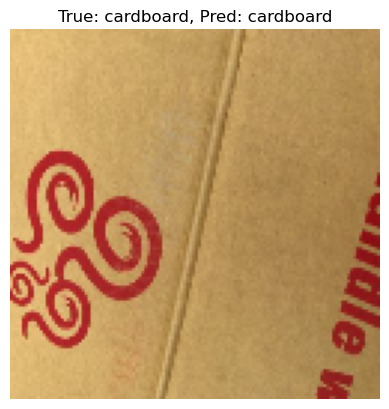

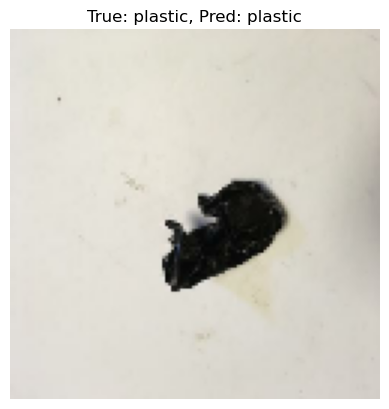

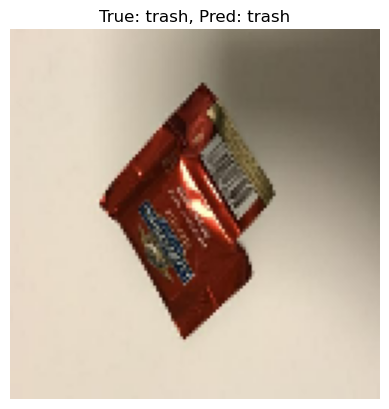

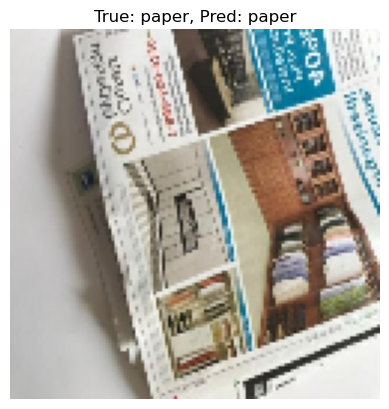

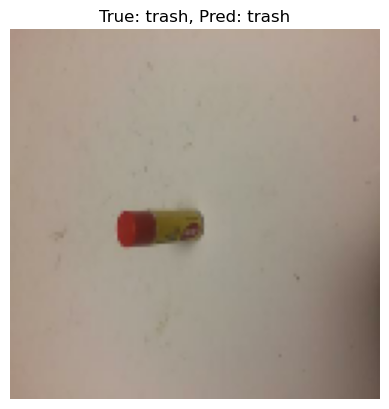

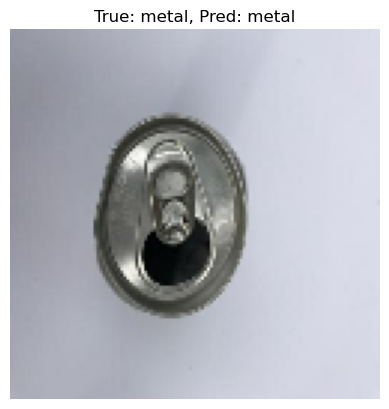

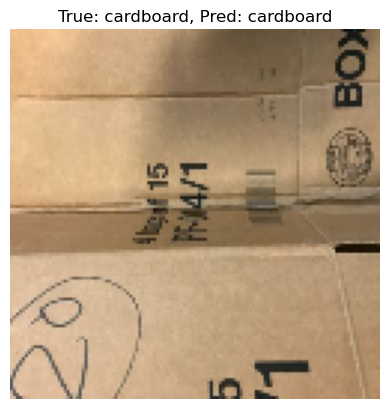

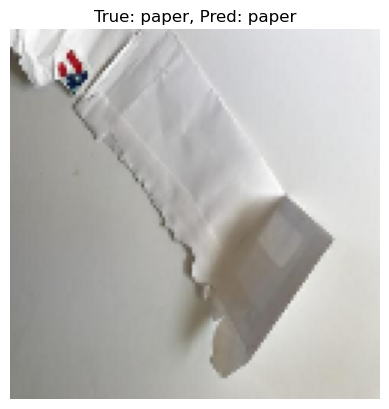

In [26]:

class_names = train_ds.class_names

for images, labels in test_ds_eval.take(1):


    predictions = model.predict(images)

    
    pred_labels = tf.argmax(predictions, axis=1)


    for i in range(8):
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")  
        plt.axis("off")  
        plt.show()


In [27]:
# Save model in Keras format with architecture, weights, and training configuration
model.save('Effiicientnetv2b2.keras')

# Load your Keras model
model = tf.keras.models.load_model('Effiicientnetv2b2.keras')


In [28]:
pip install gradio

Note: you may need to restart the kernel to use updated packages.


In [29]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

In [30]:
def classify_image(img):  
    # Resize image to 124x124 pixels (Note: Comment says 128x128, but code resizes to 124x124)
    img = img.resize((124, 124))  
    
    # Convert image to a NumPy array with float32 dtype
    img_array = np.array(img, dtype=np.float32)  
    img_array = preprocess_input(img_array)
    
    # Expand dimensions to match model input shape (adds a batch dimension)
    img_array = np.expand_dims(img_array, axis=0)  
    
    # Make a prediction using the trained model
    prediction = model.predict(img_array)  
    
    # Get the index of the highest predicted probability
    predicted_class_index = np.argmax(prediction)  
    
    # Map the predicted index to its corresponding class name
    predicted_class_name = class_names[predicted_class_index]  
    
    # Extract confidence score (probability of the predicted class)
    confidence = prediction[0][predicted_class_index]  
    
    # Return formatted prediction result with confidence score
    return f"Predicted: {predicted_class_name} (Confidence: {confidence:.2f})" 

In [31]:
iface = gr.Interface(  
    fn=classify_image,  # Function to classify image using the trained model  
    inputs=gr.Image(type="pil"),  # Accepts input as a PIL image  
    outputs="text"  # Outputs prediction as text  
)  

# Launch the interface  
iface.launch(share=True)  # Start the Gradio interface for user interaction  

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://ef8370bd4ea9855a41.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [32]:
model.save("model.h5")


TypeError: cannot pickle 'module' object

In [ ]:
model.save("model.keras")


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step


In [33]:
model.save("model.keras")